# Pulse profile optimization

In this notebook, we optimize the pulse profile used in the final computation in `main_algorithm.ipynb`. The optimization approach follows the method outlined in the paper [Quantum Optimization of Maximum Independent Set using Rydberg Atom Arrays](https://arxiv.org/abs/2202.09372).

The algorithm uses an **optimisation function** based on Gaussian processes `gp_minimize` from `scikit-optimize`.

We fix the parameters :
- The maximum Rabi frequency $\Omega_{max}$
- The minimum detuning value $\delta_0$
- The maximum detuning value $\delta_f$
- The total time of the pulse $T$

where then we create an `InterpolatedWaveform` with $2m$ parameters :
$$
{\Omega(t_i), \delta(t_i), i \in [1,m]} \text{ with } t_i = T \times i/(m+1)
$$

We apply this pulse optimization for **$m=3$** and **8 antennas** graphs. The optimal parameters for the pulse remain relatively constant. The optimized pulse parameters are then applied to identify the Maximum Independent Set (MIS) for each city and are exported in `media/optimized_values.npz`.

In [30]:
# import necessary packages
import numpy as np
import matplotlib.pyplot as plt
import scipy as scipy
from scipy.spatial import KDTree, distance
from scipy.spatial.distance import pdist, squareform
import json
from skopt import gp_minimize
# graph representation
import networkx as nx
# Pulser imports
import pulser as pulser
from pulser import Pulse, Sequence, Register
from pulser_simulation import SimConfig, QutipEmulator
from pulser import Pulse, Sequence, Register
from pulser.devices import MockDevice
from pulser.waveforms import InterpolatedWaveform

### Extract the city data

In [31]:
cities = ["Bradleymouth", "Brandonberg", "Hansenchester", "Joshuachester", "New Rebeccaberg", "North Carl", "North Christopherbury", "Port Jonathan", "Zacharyburgh", 'North Joshua']
city_name = cities[0]

with open('./data/population_{}.json'.format(city_name), 'r') as json_file:
    data = json.load(json_file)

params = data['info']
x = np.array(data['x'])
y = np.array(data['y'])

In [32]:
# function to compute coverage of an array of grid_points
def simple_coverage(population_x, population_y, grid_points, R_antennas):
    z_coverage = np.zeros(len(grid_points))
    coords = np.array([[population_x[i], population_y[i]] for i in range(len(population_x))])
    for i in range(len(grid_points)):
        start = np.array(grid_points[i])
        dist = scipy.spatial.distance.cdist(np.array([start]), coords)
        truth_table = (dist <= R_antennas)
        cov = np.sum(truth_table)
        z_coverage[i] = cov
    return z_coverage
    

### Generate a grid

We generate a triangular grid and adaptively select `max_grid_points` from the triangular grid. We take `max_grid_points` equal to 10 to minimize the time taken for Qutip emulator to run the quantum program. 

In [33]:

def generate_triangular_grid(side_lengths, spacing, offset):
    """
    Generates a grid of points in a triangular (hexagonal) lattice pattern.

    Parameters:
    - side_lengths: Tuple (rows, cols) representing the number of rows and columns in the grid.
    - spacing: Distance between adjacent points in the grid.
    - offset: Tuple (x_offset, y_offset) that shifts the entire grid by these values.

    Returns:
    - points: List of [x, y] coordinates for each point in the triangular grid.
    """
    rows, cols = side_lengths
    points = []  # Initialize an empty list to store grid points
    for row in range(rows): # Loop through each row
        for col in range(cols): # Loop through each column in the row
            # Calculate the x coordinate
            x = col * spacing
            # Offset every other row by half the side length
            if row % 2 == 1:
                x += spacing / 2
            # Calculate the y coordinate based on the row number
            y = row * (spacing * (3**0.5) / 2)  # Height of an equilateral triangle
            points.append([x + offset[0], y + offset[1]])
    return points 

# Function to adaptively select points from a triangular grid with minimum interference
def adaptive_selection_with_min_dist(grid_points, max_grid_points,interference_threshold):
    """
    Selects up to a specified number of points from a grid while ensuring a minimum distance between selected points.

    Parameters:
    - grid_points: List of [x, y] coordinates in the initial grid.
    - max_grid_points: Maximum number of points to select.
    - interference_threshold: Minimum allowable distance between any two selected points.

    Returns:
    - selected_points: List of selected [x, y] coordinates that meet the interference threshold criteria.
    """
    selected_points = []
    while len(selected_points) < max_grid_points and grid_points:
        # Choose the point with the best coverage from remaining points
        point = grid_points.pop(0)
        # Calculate interference with selected points
        if selected_points:
            dists_to_selected = distance.cdist([point], selected_points, 'euclidean')
            min_dist_to_selected = np.min(dists_to_selected)

            # Skip this point if it interferes too much with any selected point
            if min_dist_to_selected < interference_threshold:
                continue
        # Select this point
        selected_points.append(point) 
    return selected_points

In [34]:
# Define parameters
population_x = x
population_y = y
offset = [population_x.min(), population_y.min()]  # Offset to start grid at (0, 0)
R_antennas = 25  # Operating radius for each antenna
spacing = R_antennas/3  # Use a small spacing for high precision
side_lengths = (
        int(np.ceil((population_x.max() - population_x.min()) / spacing)),
        int(np.ceil((population_y.max() - population_y.min()) / spacing))
    )

max_grid_points = 8 # Maximum number of antennas
interference_threshold = 1.5*R_antennas  #minimum distance between gridpoints
grid_points = adaptive_selection_with_min_dist(generate_triangular_grid(side_lengths, spacing, offset), max_grid_points, interference_threshold)

# Calculate final coverage for the selected grid layout
z_coverage = simple_coverage(population_x, population_y, grid_points, R_antennas)

### Device selection

We choose the `MockDevice` and embedd the `grid_points` to the register coordinate with appropriate scaling.

In [35]:
device_used = MockDevice
# create an UD graph embedding using appropriate coordinates
coords = np.array(grid_points)
val = np.min(pdist(coords))
factor = 6/val
coords = coords*factor # Normalize to 6 b.c. minimum distance on real NAQC is around 6um

# set Rabi frequency and detuning 
# Parameters in rad/µs and ns
T = 2000  # duration
omega_max = 2 * np.pi
delta_0 = -6 * omega_max
delta_f = 2 * omega_max
# Size of the parameter space
m = 3
# Random instance of the parameter space
amp_params = np.random.uniform(0, omega_max, m)
det_params = np.random.uniform(delta_0, delta_f, m)

# scaling of the graph to map it inside the register
rydberg_radius = device_used.rydberg_blockade_radius(omega_max)
R_antennas = 25*factor
factor_for_rydberg_scaling = (rydberg_radius + 1e-3)/(2*R_antennas)
R_antennas = R_antennas * factor_for_rydberg_scaling
coords = coords * factor_for_rydberg_scaling

# Number of qubits
N = len(coords)
# Number of samples to probe
N_samples = 1000

# Noise configuration
noise_config = {
    "noiseless": None,
    "noisy": SimConfig(
        noise = ("SPAM", "dephasing", "doppler"),
        eta = 0.8,
        temperature = 1000,
        runs = 50,
    )
}
print('Omega_max:', omega_max)
print('Rydberg radius:', rydberg_radius)
print('Delta_0:', delta_0)
print('Delta_f:', delta_f)
print('Minimum distance:', np.min(pdist(coords)))

Omega_max: 6.283185307179586
Rydberg radius: 9.756753962298905
Delta_0: -37.69911184307752
Delta_f: 12.566370614359172
Minimum distance: 7.452607690831667


### Extract Q for the QUBO cost function

In [36]:
# interaction coefficients U_ij
Q = squareform(device_used.interaction_coeff / pdist(coords)**6)
# fill the diagonal with negative of the coverage of each grid point
np.fill_diagonal(Q, -z_coverage)

### Create the register

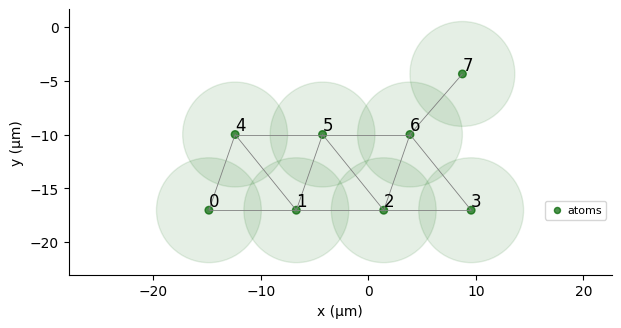

In [37]:
# create a register on NAQC
qubits = dict(enumerate(coords))
reg = Register(qubits)
reg.draw(
    blockade_radius=device_used.rydberg_blockade_radius(omega_max),
    draw_graph=True,
    draw_half_radius=True,
)

{0: Text(-14.827896147528774, -17.024109204110474, '0'),
 1: Text(-6.696434512279684, -17.024109204110474, '1'),
 2: Text(1.4350271229694045, -17.024109204110474, '2'),
 4: Text(-12.388457656954047, -9.982056858086208, '4'),
 5: Text(-4.256996021704959, -9.982056858086208, '5'),
 3: Text(9.566488758218494, -17.024109204110474, '3'),
 6: Text(3.8744656135441313, -9.982056858086208, '6'),
 7: Text(8.753342594693583, -4.3484149812667985, '7')}

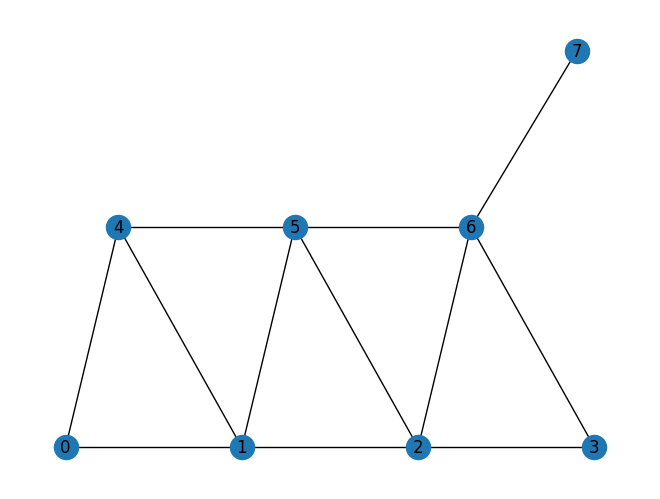

In [38]:
graph = nx.Graph()
edges = KDTree(coords).query_pairs(R_antennas * (2 + 1e-3))
graph.add_edges_from(edges)
nx.draw(graph, pos=coords)
nx.draw_networkx_labels(graph, pos=coords)

# Pulse Before optimization 

We first generate the random pulse that will be optimized. As we can see, the obtained results for the random graph are not giving a good statistical distribution.

In [59]:
def create_interp_pulse(amp_params, det_params):
    return Pulse(
        InterpolatedWaveform(T, [1e-9, *amp_params, 1e-9]),
        InterpolatedWaveform(T, [delta_0, *det_params, delta_f]),
        0,
    )

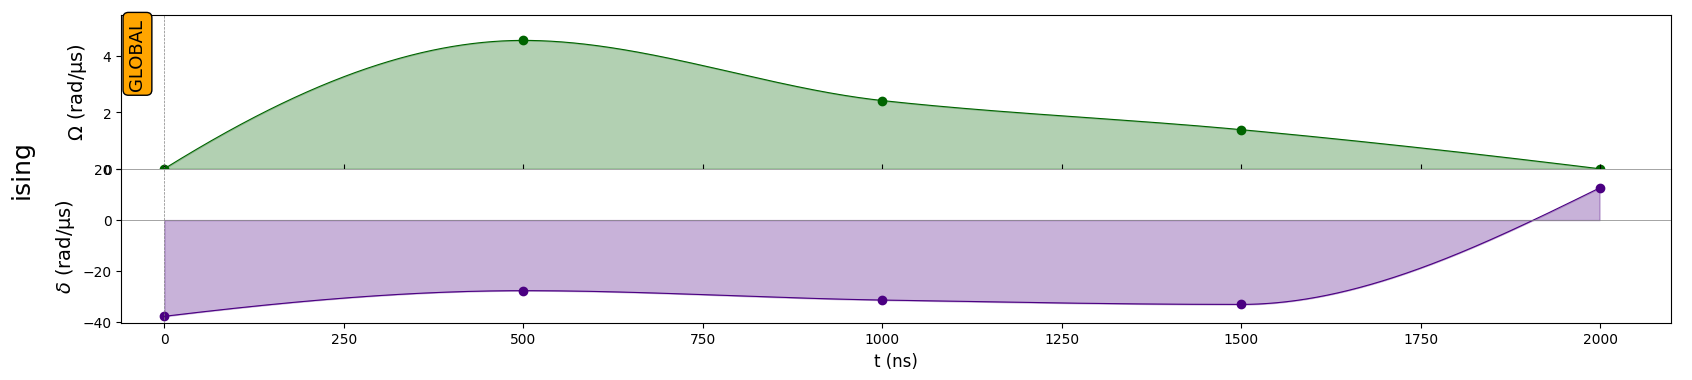

In [60]:
seq = Sequence(reg, device_used)
seq.declare_channel("ising", "rydberg_global")
seq.add(create_interp_pulse(amp_params, det_params), "ising")
seq.draw()

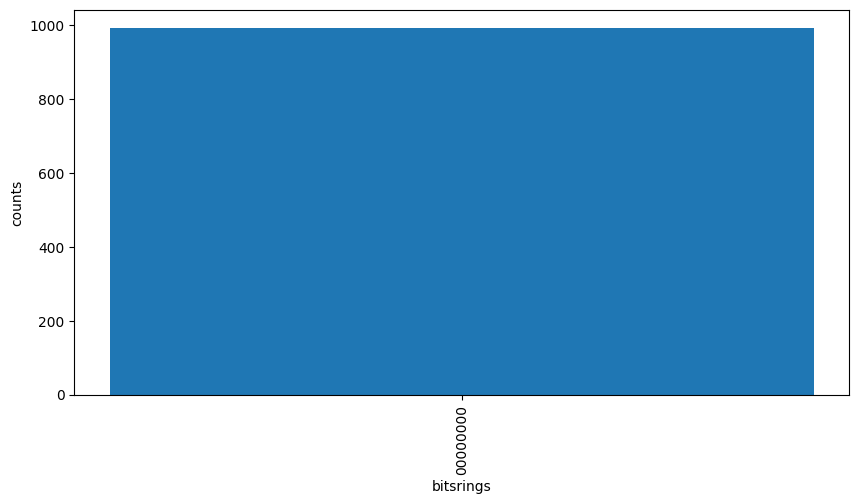

In [61]:
simulator = QutipEmulator.from_sequence(seq)
results = simulator.run()
results = simulator.run(progress_bar=False)
count_dict = results.sample_final_state(N_samples=N_samples)
most_frequent = {k:v for k,v in count_dict.items() if v>5}
C = dict(sorted(most_frequent.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(10, 5))
plt.xlabel('bitsrings')
plt.ylabel('counts')
plt.bar(C.keys(), C.values(), width=0.5)
plt.xticks(rotation="vertical")
plt.show()

# Optimization Of The Pulse

In [42]:
# Function to convert a bitstring to a list of node indices included in the set
def convert_to_indices(bitstring):
    return [i for i, bit in enumerate(bitstring) if bit == '1']

In [43]:
# Function to return the size of the Maximum Independent Set (MIS)
def mis_size(graph, bitstring):
    """
    Calculates the size of the independent set represented by the bitstring for a given graph.
    
    Parameters:
    - graph: The graph in which the independent set is being checked.
    - bitstring: A binary string representing nodes in the independent set (1 if node is in the set, 0 otherwise).
    
    Returns:
    - Size of the independent set if it is valid, otherwise a penalty (-4) if the set is not independent.
    """

    # Convert the bitstring into a list of node indices representing the independent set
    node_set = convert_to_indices(bitstring)
    
    # Check if the node set is an independent set
    for node in node_set:
        for neighbor in graph.neighbors(node):
            if neighbor in node_set:  # If any neighbor of a node in the set is also in the set, it is not an independent set
                return -4  # Return penalty if not an independent set
    
    # Return the size of the independent set if it passes the check
    return len(node_set)

# Function to calculate the weighted mean size of the MIS from a set of solutions
def mean_mis_size(graph, solution_dict):
    """
    Calculates the weighted mean size of Maximum Independent Sets (MIS) based on solutions provided in solution_dict.
    
    Parameters:
    - graph: The graph in which the MIS is being calculated.
    - solution_dict: Dictionary with bitstrings as keys and counts as values. Each bitstring represents a possible
      independent set, and the count represents how often this set was observed.
    
    Returns:
    - mean_size: The weighted mean size of the MIS across all solutions, accounting for penalties and frequencies.
    """

    total_weighted_size = 0  # Sum of weighted sizes for each solution
    total_counts = 0  # Total count of solutions
    list_sizes = []  # List to store the sizes of each solution's MIS

    # Iterate over each bitstring and its count in the solution dictionary
    for bitstring, count in solution_dict.items():
        list_sizes.append(mis_size(graph, bitstring))  # Get the size of the independent set or penalty
    
    # Identify the maximum size of all independent sets found
    max_size = max(list_sizes)
    # Replace all penalty values in list_sizes with 0 to exclude them from contributing to the mean
    updated_list_sizes = [size if size == max_size else 0 for size in list_sizes]  

    # Calculate the weighted total size and total counts for the mean
    for size, count in zip(updated_list_sizes, solution_dict.values()):
        total_weighted_size += size * count
        total_counts += count

    mean_size = total_weighted_size / total_counts

    return mean_size  # Return the mean size of the MIS

In [ ]:
def quantum_loop(params):
    """
    Executes a quantum simulation loop to evaluate the mean size of the Maximum Independent Set (MIS).

    Parameters:
    - params (list): List of pulse parameters for the interpolated pulse. The list is split into two parts:
                     the first m elements are used for amplitude, and the remaining elements for detuning.

    Returns:
    - float: The negative mean size of the MIS, calculated based on sampled states from the final quantum state.
             This is returned as a negative value to allow maximization by a minimization algorithm.
    """
    
    # Step 1: Create a quantum sequence
    seq = Sequence(reg, device_used)  # Initialize a quantum sequence with the given register and device
    seq.declare_channel("ising", "rydberg_global")  # Declare a channel named "ising" for global Rydberg interactions
    
    # Step 2: Add an interpolated pulse to the sequence
    # The pulse parameters are split into two parts: the first m elements and the rest
    seq.add(create_interp_pulse(params[:m], params[m:]), "ising")  # Add pulse to the sequence based on input parameters
    
    # Step 3: Run the quantum simulation
    simulator = QutipEmulator.from_sequence(seq, sampling_rate=0.5)  # Initialize the simulator with the sequence
    results = simulator.run(progress_bar=False)  # Run the simulation without displaying a progress bar
    
    # Step 4: Sample the final state from the results
    count_dict = results.sample_final_state(N_samples=N_samples)  # Sample the final state with N_samples
    
    # Step 5: Process and sort the sampled results
    # Create an ordered dictionary of the most frequent results, keeping only those with more than 10 occurrences
    most_frequent = {k: v for k, v in count_dict.items() if v > 10}
    results_dictionnary = dict(sorted(most_frequent.items(), key=lambda item: item[1], reverse=True))
    
    # Step 6: Calculate the mean size of the Maximum Independent Set (MIS)
    mean_size = mean_mis_size(graph, results_dictionnary)  # Calculate the mean size based on the sampled results
    
    return -mean_size  # Return the negative mean size for optimization purposes (minimization)


In [46]:
bounds = [(0.0, omega_max)] * m + [(delta_0, delta_f)] * m

n_r = 30
n_c = 120

RESULT = gp_minimize(
    quantum_loop, bounds, n_random_starts=n_r, n_calls=n_c, verbose=False
)

In [47]:
def sort_improv(RESULT):
    """
    Generates a list of minimum scores encountered at each step in an optimization result,
    maintaining a cumulative minimum score history.

    Parameters:
    - RESULT (object): An object containing optimization results, including `func_vals`, 
                       which is a list of function values (scores) obtained at each iteration.

    Returns:
    - list: A list of cumulative minimum scores encountered up to each iteration.
    """
    
    # Retrieve the function values (scores) from the optimization results
    score_vals = RESULT.func_vals
    
    # Initialize the minimum score with the first function value
    min = score_vals[0]
    
    # Initialize a list to store the cumulative minimum scores
    score_list = []
    
    # Iterate through each score value
    for s in score_vals:
        # Update the minimum score if a new lower score is found
        if s < min:
            min = s
        # Append the current minimum score to the list
        score_list.append(min)
    
    return score_list


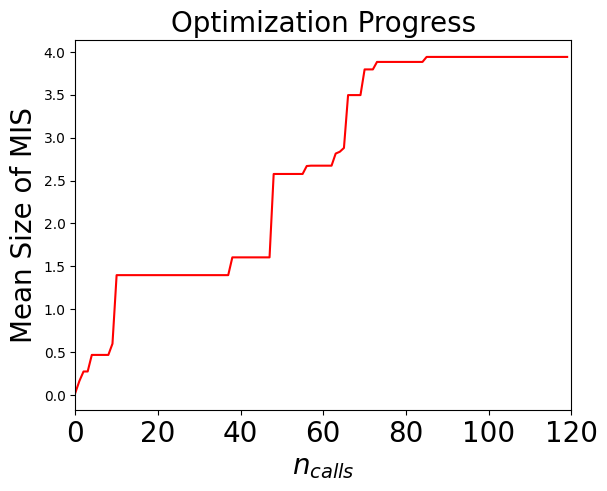

In [48]:
fig = plt.figure()
plt.plot(range(n_c), np.abs(sort_improv(RESULT)), "r-")
plt.title("Optimization Progress", fontsize=20)
plt.xlabel(r"$n_{calls}$", fontsize=20)
plt.ylabel("Mean Size of MIS", fontsize=20)
plt.xlim(0, n_c)
plt.xticks(fontsize=20)
plt.show()

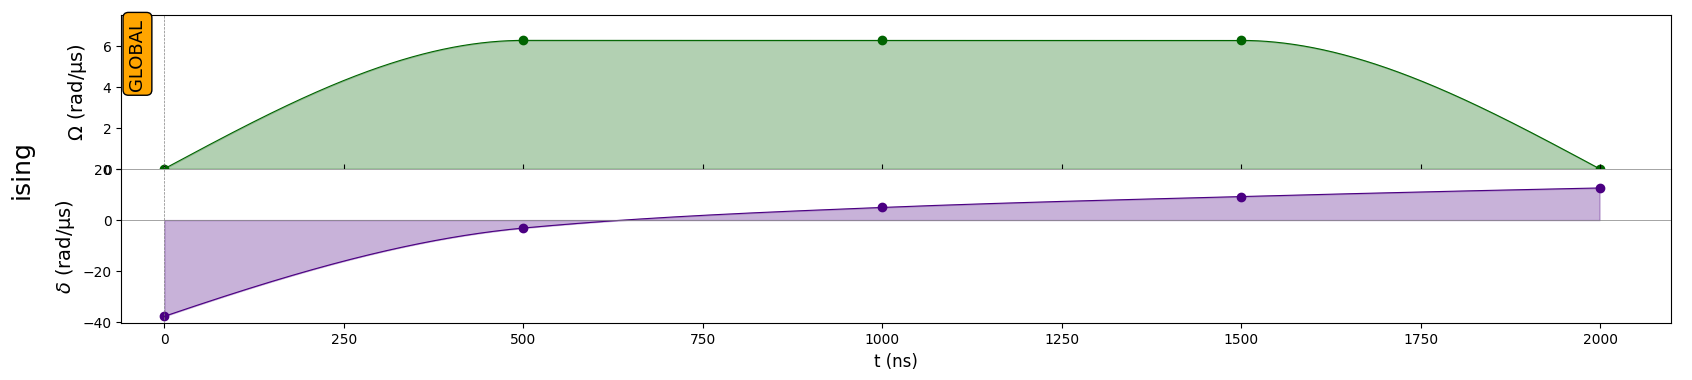

In [52]:
new_seq = Sequence(reg, device_used)
new_seq.declare_channel("ising", "rydberg_global")
P = create_interp_pulse(RESULT.x[:m], RESULT.x[m:])
new_seq.add(P, "ising")
new_seq.draw()

In [62]:
# storing the optimized data
np.savez("./media/optimized_values.npz", param=RESULT.x, delta_0=delta_0, delta_f=delta_f, omega_max=omega_max, T=T)

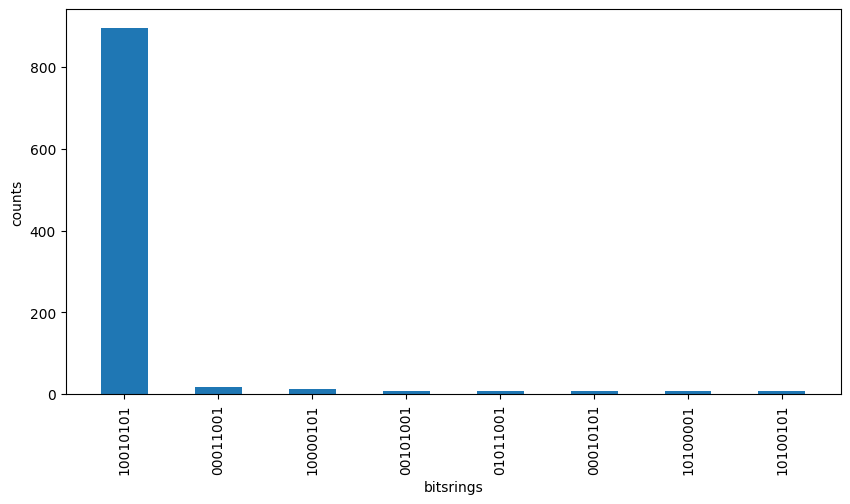

In [58]:
simulator = QutipEmulator.from_sequence(new_seq)
results = simulator.run()
count_dict = results.sample_final_state(N_samples=N_samples)
most_frequent = {k:v for k,v in count_dict.items() if v>5}
C = dict(sorted(most_frequent.items(), key=lambda item: item[1], reverse=True))

plt.figure(figsize=(10, 5))
plt.xlabel('bitsrings')
plt.ylabel('counts')
plt.bar(C.keys(), C.values(), width=0.5)
plt.xticks(rotation="vertical")
plt.show()


Most weighted independent set: 10010101 with counts 908
Most counts independent set: 10010101 with counts 908


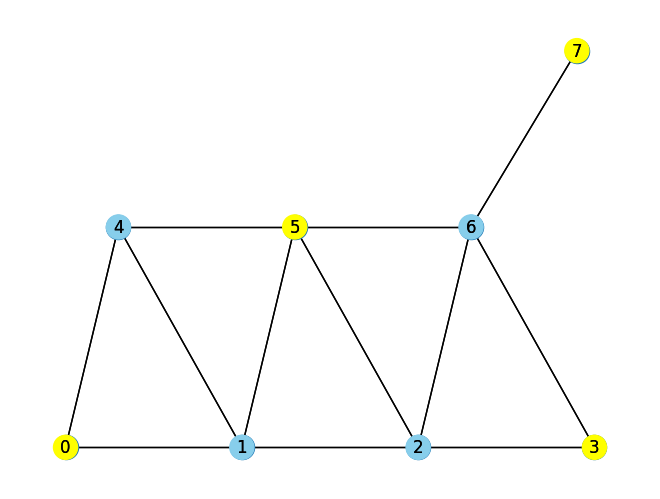

In [55]:
# Sort the bitstrings in descending order by frequency
solution = [key for key, value in sorted(most_frequent.items(), key=lambda item: item[1], reverse=True)]

# Function to convert a bitstring to a list of node indices included in the set
def convert_to_indices(bitstring):
    return [i for i, bit in enumerate(bitstring) if bit == '1']

# Function to check if a set of nodes is an independent set
def is_independent_set(graph, node_indices):
    for node in node_indices:
        for neighbor in graph.neighbors(node):
            if neighbor in node_indices:
                return False
    return True

# Find the maximum weight for valid independent sets
list_weights = []
valid_solutions = []
for sol in solution:
    highlighted = convert_to_indices(sol)
    # Check if highlighted nodes form an independent set
    if is_independent_set(graph, highlighted):
        valid_solutions.append(sol)
        list_weights.append(np.sum(highlighted))


# If there are valid independent sets, find the one with the maximum weight
if valid_solutions:
    ind_max = np.argmax(list_weights)
    highlighted_nodes = convert_to_indices(valid_solutions[ind_max])
    print(f'Most weighted independent set: {valid_solutions[ind_max]} with counts {C[str(valid_solutions[ind_max])]}')
    print(f'Most counts independent set: {solution[0]} with counts {C[str(solution[0])]}')
else:
    highlighted_nodes = []  # No valid independent set found

# Draw the graph with colored nodes
nx.draw(graph, pos=coords)
nx.draw_networkx_labels(graph, pos=coords)

# Assign colors: 'yellow' for highlighted nodes, 'skyblue' for others
node_colors = ['yellow' if node in highlighted_nodes else 'skyblue' for node in graph.nodes()]

nx.draw(graph, pos=coords, node_color=node_colors, with_labels=True)